## IMDB review sentiment Analysis


#### Μέλη Ομάδας:
- Ευάγγελος Λευτάκης : 3200093
- Ρέα Σκλήκα : 3210181
- Σοφία-Ζωή Σωτηρίου : 3210192

### Dependencies

In [22]:
# %pip install -U pandas
# %pip install -U numpy
# %pip install -U scipy
# %pip install -U tensorflow
# %pip install -U scikit-learn
#%pip install -U pydot
%pip install -U seaborn
%pip install --upgrade kerasplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from math import log
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,  classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.linear_model import LogisticRegression as skLogReg
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import learning_curve
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.metrics import roc_curve as skroc_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve
from scipy.special  import expit, logsumexp
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf

%matplotlib inline

### Part 1

#### Data Preperation
First We Prepare the train and test data and create a binary representation of it.

In [4]:
(x_train_imdb, y_train), (x_test_imdb, y_test) = tf.keras.datasets.imdb.load_data()


word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])

binary_vectorizer = CountVectorizer(binary=True, min_df=100,stop_words="english")
x_train = binary_vectorizer.fit_transform(x_train_imdb)
x_test = binary_vectorizer.transform(x_test_imdb)
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)
x_train = x_train.astype(int)
x_test = x_test.astype(int)

x_train = x_train.toarray()
x_test = x_test.toarray()



Vocabulary size: 3563


#### Learning Curve Implementation

In [2]:
def my_learning_curve(estimator, X, y  ,train_sizes, scoring, title, cv=5):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = estimator,
    X = X,
    y = y, 
    train_sizes = train_sizes,
    cv=cv,
    scoring = scoring)
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    plt.plot(train_sizes,  train_scores_mean, label = 'Training accuracy')
    plt.plot(train_sizes,  validation_scores_mean, label = 'Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Training set size')
    plt.title(title, y = 1.03)
    plt.legend()
    plt.show()

    learning_curve_df = pd.DataFrame({
        'Training Set Size': train_sizes,
        'Training Accuracy': train_scores_mean,
        'Validation Accuracy': validation_scores_mean
    })
    learning_curve_df.set_index('Training Set Size', drop=True, inplace=True)
    # Printing the table
    print("\nLearning Curve Data:")
    display(learning_curve_df)

#### Logistic Regression:


In [4]:
class LogisticRegression():
   

    def __init__(self,epochs=20,learning_rate=0.001,threshold=0.5, regularization_factor=1):
        self.epochs=epochs;
        self.learning_rate=learning_rate
        self.weights = np.array([])
        self.threshold=threshold
        self.regularization_factor = regularization_factor
        
    
    def set_threshold(self,value):
        self.threshold = value
    def get_threshold(self):
        return self.threshold
    def sigmoid(self , t):
        return 1/(1+np.exp(-t))


    def fit(self,x_train_input,y_train_input):
        ''' '''
        feature_vector_length = x_train_input.shape[1]
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]

        # We prepare the array by adding a column of 1s
        # for the w0 weight
        ones_column = np.ones(x_train.shape[0])
        x_train = np.insert(x_train, 0, ones_column, axis=1)
        self.weights = self.initialize_weights(feature_vector_length)
        
        for epoch in range(self.epochs):
            suffled_indices = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[suffled_indices]
            y_train_shuffled = y_train[suffled_indices]
            for i in range(x_train.shape[0]):
                x_i = x_train_shuffled[i-1]
                y_i = y_train_shuffled[i-1]

                self.update_weights(x_i,y_i)
        x_train = np.delete(x_train, 0, axis=1)                 #remove 1s column again (needed previously for w0)

        return self.evaluate(y_train,self.predict(x_train))


        
    
    def predict(self, x_test):
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []

        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            predicted_class = 1 if probability_positive >= self.threshold else 0
            y_test_predicted.append(predicted_class)

        x_test = np.delete(x_test, 0, axis=1)
        return np.array(y_test_predicted)

    def predict_proba(self, x_test):
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []

        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            y_test_predicted.append([probability_positive,(1-probability_positive)])
        x_test = np.delete(x_test, 0, axis=1)
        return np.array(y_test_predicted)
    
    def get_params(self, deep=True):
        return {
            'epochs': self.epochs,
            'learning_rate': self.learning_rate,
            'threshold': self.threshold,
            'regularization_factor': self.regularization_factor
        }


    @staticmethod
    def initialize_weights(size):
        '''We Initialize the weights with random values with a mean of 0 and a standard deviation of 0.01
          This is a common practice to prevent the weights from being too large at the begining '''
        return np.random.randn(size+1) * 0.01

    def update_weights(self,x_test,y_test):
        predicted_prob = self.sigmoid(np.dot(self.weights,x_test))
        gradient = ((y_test - predicted_prob) * x_test)
        self.weights = (1 - 2*self.regularization_factor*self.learning_rate) * self.weights + self.learning_rate * gradient 
    
    def evaluate(self, y_true, y_predicted, verbose=False):
        precision = precision_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted)
        f1 = f1_score(y_true, y_predicted)
        if verbose:
            print(classification_report(y_true, y_predicted))
            print("Threshold: "+str(self.threshold))
        return np.array([precision,recall,f1])
    

    def classification_diagrams(self,x_train, y_train,x_test, y_test, train_sizes):
        precisions = np.array([])
        recalls = np.array([])
        f1 = np.array([])
        
        for size in train_sizes:
            x_train_temp, y_train_temp = x_train[:size], y_train[:size]
            self.fit(x_train_temp,y_train_temp)
            y_predicted = self.predict(x_test)
            evaluation = self.evaluate(y_test,y_predicted,verbose=False)
            precisions = np.append(precisions, evaluation[0])
            recalls = np.append(recalls, evaluation[1])
            f1 = np.append(f1, evaluation[2])

        fig, (ax1, ax2, ax3) = plt.subplots(3)
        fig.suptitle('Logistic Regression Results')

        ax1.plot(train_sizes, precisions,label='Precision', color='blue')
        ax1.legend()

        ax2.plot(train_sizes, recalls,label='Recall', color='red')
        ax2.legend()
        
        ax3.plot(train_sizes, f1, label='f1-score', color='green')
        ax3.legend()
        
        plt.show()


        results_df = pd.DataFrame({
        'Training Set Size': train_sizes,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1
        })
        results_df.set_index('Training Set Size', drop=True, inplace=True)
        # Printing the table
        print("\nLogistic Regression Results:")
        display(results_df)
    
    def custom_classification_report(self,x_train, y_train,x_test, y_test, train_sizes):
        self.classification_diagrams(x_train, y_train,x_test, y_test, train_sizes)
        my_learning_curve(estimator = self, X = x_train, y = y_train,  train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title="Logistic Regression Learning Curve")


    

##### Results
Here we try out the Logistic Regression learning algorithm

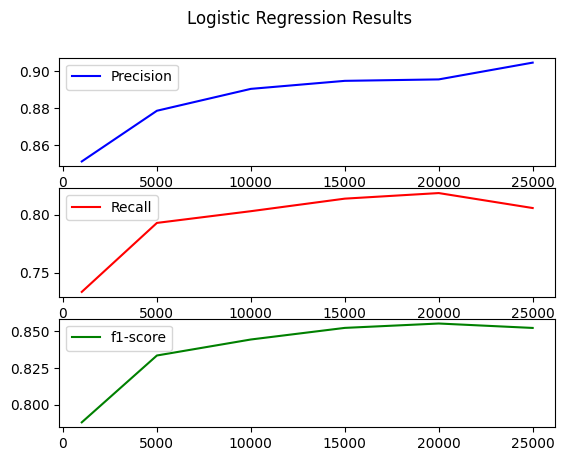


Logistic Regression Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.851095,0.73344,0.787900
5000,0.878624,0.79280,0.833509
10000,0.890506,0.80288,0.844426
15000,0.894862,0.81368,0.852342
20000,0.895649,0.81848,0.855328
25000,0.904762,0.80560,0.852306


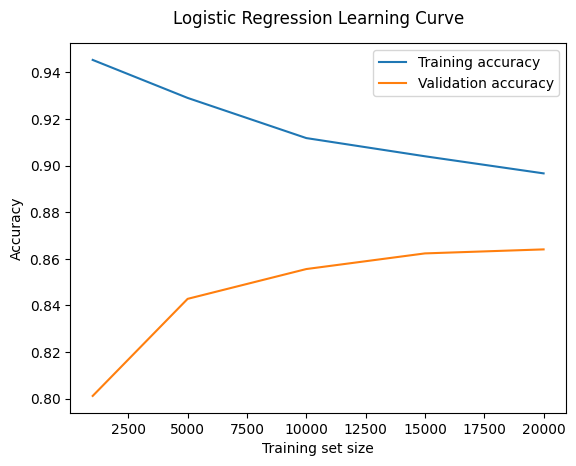


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.945400,0.80112
5000,0.929080,0.84280
10000,0.911840,0.85560
15000,0.904027,0.86232
20000,0.896680,0.86404


In [5]:
LogReg = LogisticRegression(100,threshold=0.6, regularization_factor=0.001)

LogReg.custom_classification_report(x_train=x_train,y_train=y_train,x_test=x_test, y_test=y_test, train_sizes = [1000,5000,10000,15000,20000,25000])


#### Naive Bayes:

In [10]:
class NaiveBayes: 
    def __init__(self,alpha=1):
            self.probabilityC1= None #probabilityC0 = 1 -probabilityC1
            self.boundProbabilityC0 = None 
            self.boundProbabilityC1 = None
            self.alpha = alpha

    def fit(self, x_train_input, y_train_input): 
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]
        
        # x_train = x_train_input
        # y_train = y_train_input
        #x_train.todense()
        #x_train.toarray()
        numberOfExamples = x_train.shape[0]
        numberOfFeatures = x_train.shape[1]
        #y_train = y_train.flatten()

        #negativeReviews = 1 - positiveReviews
        positiveReviews = 0
        positiveReviews = np.sum(y_train)
        self.probabilityC1 = positiveReviews / numberOfExamples

        '''
        C0: P( X(i) = 0 | C = 0) and C1 = P ( X(i) = 0 | C = 1)
        P( X(i) = 1 | C = 0) = 1 - P( X(i) = 0 | C = 0) and P( X(i) = 1 | C = 1) = P( X(i) = 0 | C = 1)
        '''
        self.boundProbabilityC0 = np.ones(numberOfFeatures) * self.alpha
        self.boundProbabilityC1 = np.ones(numberOfFeatures) * self.alpha
        for i in range(numberOfFeatures): 
            #For every word that is not on a review add to the array correspnding to the review result of the example
            for j in range(numberOfExamples):  
                if y_train[j] == 0 and x_train[j][i] == 0: 
                    self.boundProbabilityC0[i] += 1 
                elif y_train[j] == 1 and x_train[j][i] == 0: 
                    self.boundProbabilityC1[i] += 1 
        """
        Adding Laplace estimator with an alpha value of 1
        """
        self.boundProbabilityC0 = [(x + self.alpha) / (numberOfExamples - positiveReviews + 2 * self.alpha) for x in self.boundProbabilityC0]
        self.boundProbabilityC1 = [(x + self.alpha) / (positiveReviews + 2 * self.alpha) for x in self.boundProbabilityC1]


    def get_params(self, deep=True):
        return {'alpha': self.alpha}

    def predict(self, x_test):
        prediction = list()
        numberOfFeatures = x_test.shape[1]

        for x in x_test:
            positiveReviewProbability = log(self.probabilityC1)
            negativeReviewProbability = log(1 - self.probabilityC1)
            for y in range(numberOfFeatures): 
                if x[y] == 1:
                    positiveReviewProbability += log(max(1e-10, 1 - self.boundProbabilityC1[y]))
                    negativeReviewProbability += log(max(1e-10, 1 - self.boundProbabilityC0[y]))
                elif x[y] == 0: 
                    positiveReviewProbability += log(self.boundProbabilityC1[y])
                    negativeReviewProbability += log(self.boundProbabilityC0[y])
            if positiveReviewProbability > negativeReviewProbability: 
                prob = 1
            elif negativeReviewProbability > positiveReviewProbability: 
                prob = 0

            prediction.append(prob)

        return np.array(prediction)
    
    def predict_proba(self, x_test):
        prediction = list()
        numberOfFeatures = x_test.shape[1]
        for x in x_test:
            positiveReviewProbability = log(self.probabilityC1)
            negativeReviewProbability = log(1 - self.probabilityC1)
            for y in range(numberOfFeatures): 
                if x[y] == 1:
                    positiveReviewProbability += log(max(1e-10, 1 - self.boundProbabilityC1[y]))
                    negativeReviewProbability += log(max(1e-10, 1 - self.boundProbabilityC0[y]))
                elif x[y] == 0: 
                    positiveReviewProbability += log(self.boundProbabilityC1[y])
                    negativeReviewProbability += log(self.boundProbabilityC0[y])
            
            log_probabilities = [positiveReviewProbability, negativeReviewProbability]

            # Normalize using logsumexp
            log_normalization = logsumexp(log_probabilities)

            # Calculate normalized probabilities
            prob_positive = np.exp(positiveReviewProbability - log_normalization)

            prediction.append([prob_positive, 1-prob_positive])
            # print("pos_log_p: "+ str(positiveReviewProbability) + ", neg_log_p: "+str(negativeReviewProbability) + " \nprob_pos: " + str(prob_positive))

        return np.array(prediction)
    
    def evaluate(self, y_true, y_predicted, verbose=False):
        precision = precision_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted)
        f1 = f1_score(y_true, y_predicted)
        if verbose:
            print(classification_report(y_true, y_predicted))
            print("Threshold: "+str(self.threshold))
        return np.array([precision,recall,f1])

    def classification_diagrams(self,x_train, y_train,x_test, y_test, train_sizes):
        precisions = np.array([])
        recalls = np.array([])
        f1 = np.array([])
        
        for size in train_sizes:
            x_train_temp, y_train_temp = x_train[:size], y_train[:size]
            self.fit(x_train_temp,y_train_temp)
            y_predicted = self.predict(x_test)
            evaluation = self.evaluate(y_test,y_predicted,verbose=False)
            precisions = np.append(precisions, evaluation[0])
            recalls = np.append(recalls, evaluation[1])
            f1 = np.append(f1, evaluation[2])

        fig, (ax1, ax2, ax3) = plt.subplots(3)
        fig.suptitle('Naive Bayes Results')

        ax1.plot(train_sizes, precisions,label='Precision', color='blue')
        ax1.legend()

        ax2.plot(train_sizes, recalls,label='Recall', color='red')
        ax2.legend()
        
        ax3.plot(train_sizes, f1, label='f1-score', color='green')
        ax3.legend()
        
        plt.show()


        results_df = pd.DataFrame({
        'Training Set Size': train_sizes,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1
        })
        results_df.set_index('Training Set Size', drop=True, inplace=True)
        # Printing the table
        print("\nNaive Bayes Results:")
        display(results_df)
    
    def custom_classification_report(self,x_train, y_train,x_test, y_test, train_sizes):
        self.classification_diagrams(x_train, y_train,x_test, y_test, train_sizes)
        my_learning_curve(estimator = self, X = x_train, y = y_train,  train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title="Naive Bayes Learning Curve")

    



##### Results:

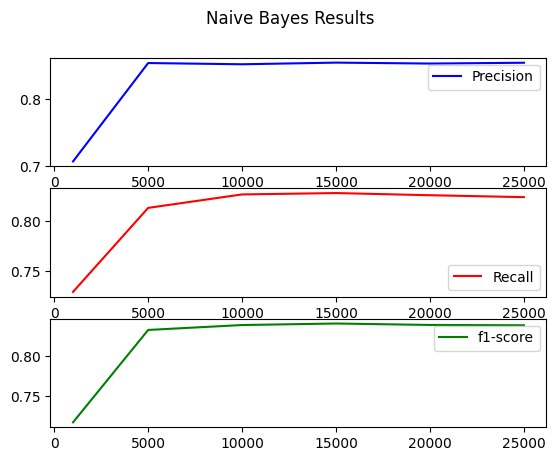


Naive Bayes Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.706827,0.72888,0.717684
5000,0.853280,0.81280,0.832548
10000,0.851443,0.82624,0.838652
15000,0.853900,0.82760,0.840544
20000,0.852516,0.82544,0.838760
25000,0.853707,0.82352,0.838342


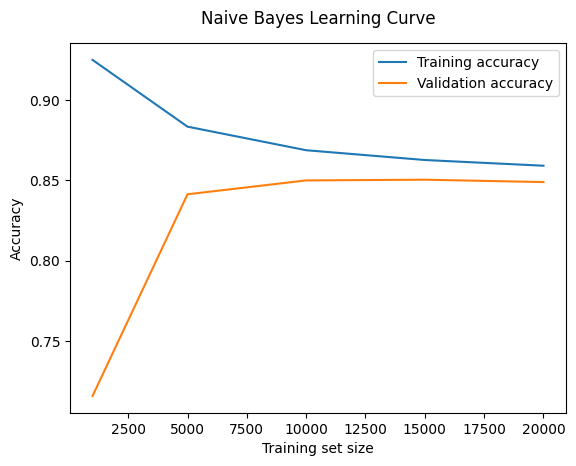


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.924800,0.71576
5000,0.883280,0.84120
10000,0.868620,0.84984
15000,0.862533,0.85028
20000,0.858980,0.84880


In [11]:
NB = NaiveBayes()
NB.fit(x_train,y_train)
y_predicted = NB.predict(x_test)

NB.custom_classification_report(x_train=x_train,y_train=y_train,x_test=x_test, y_test=y_test, train_sizes = [1000,5000,10000,15000,20000,25000])



#### [AdaBoost:](Machine-Learning-Algorithms/AdaBoost.py)

In [12]:
class AdaBoost:
    def __init__(self,amount_of_says=None, models = None):
        self.models = models if models is not None else []
        self.weights = []
        self.amount_of_says = amount_of_says if amount_of_says is not None else []
    
    def get_params(self, deep=True):
        return {'amount_of_says': self.amount_of_says,
                'models': self.models,
                }

    def fit (self, x_train_input, y_train_input, M):
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]

        y_train = 2 * y_train - 1
        y_dev = 2 * y_dev - 1
        # initializing weights equally
        self.weights = np.ones(x_train.shape[0]) / x_train.shape[0]
        m = 0 
        epsilon = 1e-10                                                     # Small epsilon value to avoid division by zero
        while m < M:
            # create the base learner (decision stumps)
            stump = tree.DecisionTreeClassifier(max_depth=1)
            stump = stump.fit(x_train,y_train,self.weights)
            y_pred = stump.predict(x_train)
            error = self.calculate_error(y_train, y_pred, self.weights)
            alpha =1/2 *np.log((1-error)/(error+epsilon))
            self.change_weights(y_pred, y_train, alpha)
            x_train, y_train = self.updateData(x_train, y_train)
            if error >= 0.5:
                m -= 1
            else:
                self.models.append(stump)
                self.amount_of_says.append(alpha)
                m +=1
        y_dev_predicted = self.predict(x_dev)
        return self.evaluate(y_dev,y_dev_predicted)

    def calculate_error(self, y, y_pred, w):
        return (sum(w*(np.not_equal(y, y_pred)).astype(int)))

    # make a new empty dataset the same size as the original and pick a random number [0..1)
    # and see where that number falls when the sample weights are used like a distribution
    # fill the new dataset with those values 
    def updateData(self, x, y):
        distribution = np.cumsum(self.weights)
        newDataset = np.zeros_like(x)
        temp_y = np.zeros_like(y)
        for i in range (x.shape[0]):
            number = np.random.rand()
            index = np.searchsorted(distribution, number)
            newDataset[i, :] = x[index, :]
            temp_y[i] = y[index]
        self.weights = np.ones(x.shape[0]) / x.shape[0]

        return newDataset, temp_y

    # increase the weights of false predictions and decrease the others 
    def change_weights(self, pred, y, amount_of_say):
        for i in range(y.shape[0]):
            if ((pred[i]==y[i])):
                self.weights[i] *= np.exp(-amount_of_say)
            else:
                self.weights[i] *= np.exp(amount_of_say)
        # normalize the weights
        self.weights = self.weights/np.sum(self.weights)

        
    def predict(self, x):
        predictions = np.zeros(x.shape[0])
        for i in range(len(self.models)):
            stump = self.models[i].predict(x)
            for example in range(x.shape[0]):
                predictions[example] += self.amount_of_says[i] * stump[example]
        # Final prediction is based on the sign of the weighted sum
        final_predictions = np.where(predictions >= 0, 1, -1)
        return final_predictions
    
    def evaluate(self, y_true, y_predicted):
        precision = precision_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted)
        f1 = f1_score(y_true, y_predicted)
        return np.array([precision,recall,f1])
    
    def custom_classification_report(self,x_train, y_train,x_test, y_test, train_sizes):
        self.classification_diagrams(x_train, y_train,x_test, y_test, train_sizes)
        my_learning_curve(estimator = self, X = x_train, y = y_train,  train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title="AdaBoost Learning Curve")

    def classification_diagrams(self,x_train, y_train,x_test, y_test, train_sizes):
        precisions = np.array([])
        recalls = np.array([])
        f1 = np.array([])
        y_test = 2*y_test-1
        for size in train_sizes:
            x_train_temp, y_train_temp = x_train[:size], y_train[:size]
            self.fit(x_train_temp,y_train_temp, 70)
            y_predicted = self.predict(x_test)
            evaluation = self.evaluate(y_test,y_predicted)
            precisions = np.append(precisions, evaluation[0])
            recalls = np.append(recalls, evaluation[1])
            f1 = np.append(f1, evaluation[2])

        fig, (ax1, ax2, ax3) = plt.subplots(3)
        fig.suptitle('AdaBoost Results')

        ax1.plot(train_sizes, precisions,label='Precision', color='blue')
        ax1.legend()

        ax2.plot(train_sizes, recalls,label='Recall', color='red')
        ax2.legend()
        
        ax3.plot(train_sizes, f1, label='f1-score', color='green')
        ax3.legend()
        
        plt.show()


        results_df = pd.DataFrame({
        'Training Set Size': train_sizes,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1
        })
        results_df.set_index('Training Set Size', drop=True, inplace=True)
        # Printing the table
        print("\nAdaBoost Results:")
        display(results_df)

##### Results:

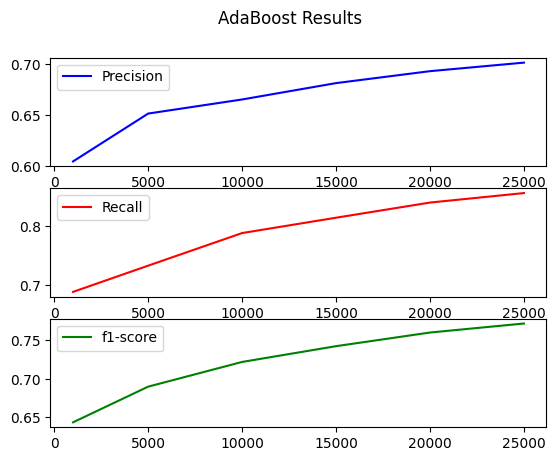


AdaBoost Results:


,Precision,Recall,F1-Score
Training Set Size,,,
1000,0.604797,0.68792,0.643686
5000,0.651540,0.73280,0.689785
10000,0.665294,0.78856,0.721702
15000,0.681271,0.81480,0.742077
20000,0.692932,0.84072,0.759705
25000,0.701277,0.85696,0.771341


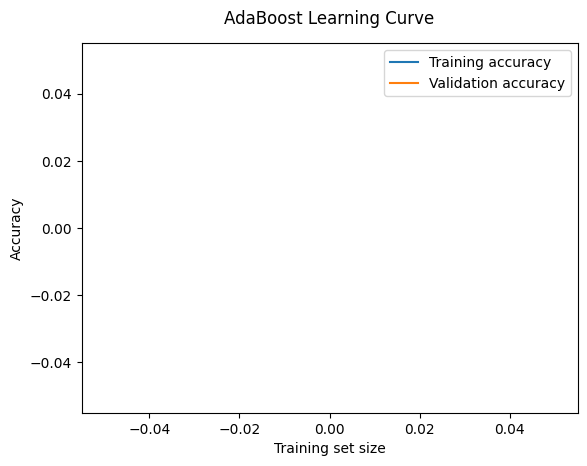


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,NaN,NaN
5000,NaN,NaN
10000,NaN,NaN
15000,NaN,NaN
20000,NaN,NaN


In [13]:
AB = AdaBoost()
AB.custom_classification_report(x_train, y_train, x_test, y_test, [1000,5000,10000,15000,20000,25000])

### Part 2:
In this Part we are going to compare the algorithms we wrote to the ones from the sci-kit learn library

#### Diagrams
For the comparison of our algorithm implementations with those of scikit learn we have created some curves to help visualize the performance

In [9]:
# Precision Recall Curve
def pr_curves(classifiers,data,type,size=20):
    classifier1 = classifiers[0]
    classifier2 = classifiers[1]
    currentThreshold = 0
    if type=='LG':
        original_threshold = classifier1.get_threshold()
    if type=='NB':
        y_pred_proba1 = classifier1.predict_proba(data[0])[:, 0]
        y_pred_proba2 = classifier2.predict_proba(data[0])[:, 1]
    if type=="AB":
        y_pred_proba1 = classifier1.predict(data[0])[:,0]
        y_pred_proba2 = classifier2.predict(data[0])[:,1] 
    precisions1 = []
    recalls1 = []
    precisions2 = []
    recalls2 = []
    
    for i in range(size):
        currentThreshold += 1./size
        if (currentThreshold>0.3 and currentThreshold<0.75):
            if type == 'LG':
                #Classifier 1
                classifier1.set_threshold(currentThreshold)
                results = classifier1.evaluate(data[1],classifier1.predict(data[0]))
                recalls1.append(results[0])
                precisions1.append(results[1])

                #classifier 2
                y_pred_proba = classifier2.predict_proba(data[0])[:, 1]  # Probability estimates for the positive class
                y_pred_custom_threshold = (y_pred_proba > currentThreshold).astype(int)
                recalls2.append(recall_score(data[1],y_pred_custom_threshold))
                precisions2.append(precision_score(data[1],y_pred_custom_threshold))
            elif type == 'NB':
                #Classifier 1
                y_pred_custom_threshold1 = (y_pred_proba1 > currentThreshold).astype(int)
                results = classifier1.evaluate(data[1],y_pred_custom_threshold1)
                recalls1.append(results[0])
                precisions1.append(results[1])

                #classifier 2
                y_pred_custom_threshold2 = (y_pred_proba2 > currentThreshold).astype(int)
                results = classifier1.evaluate(data[1],y_pred_custom_threshold2)
                recalls2.append(recall_score(data[1],y_pred_custom_threshold2,zero_division=1))
                precisions2.append(precision_score(data[1],y_pred_custom_threshold2, zero_division=1))

            elif type == 'AB':
                #Classifier 1
                y_pred_custom_threshold1 = (y_pred_proba1 > currentThreshold).astype(int)
                results = classifier1.evaluate(data[1],y_pred_custom_threshold1)
                recalls1.append(results[0])
                precisions1.append(results[1])

                #classifier 2
                y_pred_custom_threshold2 = (y_pred_proba2 > currentThreshold).astype(int)
                results = classifier1.evaluate(data[1],y_pred_custom_threshold2)
                recalls2.append(recall_score(data[1],y_pred_custom_threshold2,zero_division=1))
                precisions2.append(precision_score(data[1],y_pred_custom_threshold2, zero_division=1))
    
    if type == 'LG':
        classifier1.set_threshold(original_threshold)

    plt.plot(recalls1, precisions1 ,label='our curve')
    plt.plot(recalls2, precisions2 ,label='sci-kit learn')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Diagram')
    plt.legend()
    plt.show()

def pr(classifier,data,type):
    
    precisions1, recalls1, threshold = precision_recall_curve(data[1], classifier.predict(data[0]))
    print(precisions1, recalls1, threshold)
    plt.plot(recalls1, precisions1 ,label=type+' curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Diagram')
    plt.legend()
    plt.show()

def roc_curve(classifiers,data):
    classifier1=classifiers[0]
    classifier2=classifiers[1]

    fpr1, tpr1, thresh1 = skroc_curve(data[1], classifier1.predict_proba(data[0])[:,0],pos_label=1)
    fpr2, tpr2, thresh2 = skroc_curve(data[1], classifier2.predict_proba(data[0])[:,1], pos_label=1)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = skroc_curve(data[1], random_probs, pos_label=1)
    auc_score1 = roc_auc_score(data[1], classifier1.predict_proba(data[0])[:,0])
    auc_score2 = roc_auc_score(data[1], classifier2.predict_proba(data[0])[:,1])
    plt.plot(fpr1, tpr1, linestyle='--',color='purple', label='Our Logistic Regression, AUC='+str(auc_score1))
    plt.plot(fpr2, tpr2, linestyle='--',color='blue', label='Sci kit learn, AUC ='+str(auc_score2))
    plt.plot(p_fpr, p_tpr, linestyle='--', color='green')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();

    

#### Logistic Regression
In this part we will compare our logistic regression algorithm with that of sci-kit learn using the diagrams above 

In [11]:
# First we initialize the classifiers
our_logistic_regression = LogisticRegression(epochs=100,threshold=0.6, regularization_factor=0.001)
scikit_logistic_regression = skLogReg(max_iter=1000)


# Fit the training data to the classifiers
fit_eval = our_logistic_regression.fit(x_train,y_train)
scikit_logistic_regression.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

##### Learning Curves

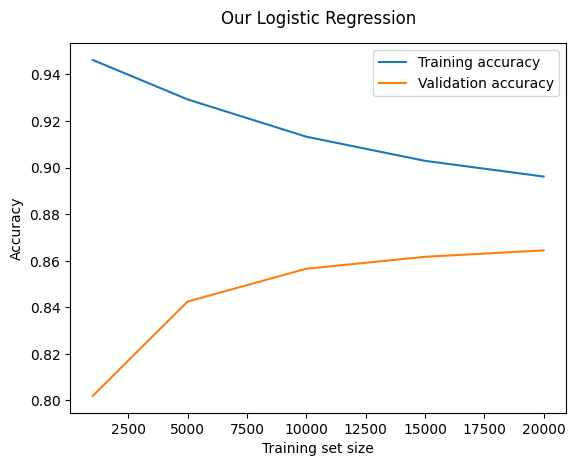


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.94620,0.80196
5000,0.92924,0.84248
10000,0.91324,0.85656
15000,0.90288,0.86168
20000,0.89614,0.86444


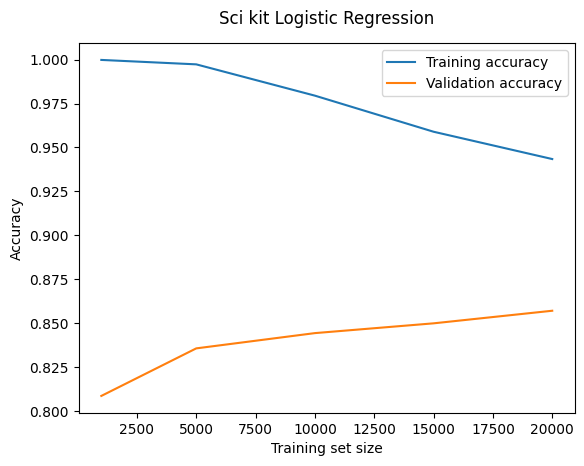


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.99980,0.80872
5000,0.99728,0.83576
10000,0.97948,0.84444
15000,0.95896,0.85000
20000,0.94343,0.85716


In [12]:
# Learning curve for our classifiers
my_learning_curve(estimator = our_logistic_regression, X = x_train, y = y_train, train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title="Our Logistic Regression")
my_learning_curve(estimator = scikit_logistic_regression, X = x_train, y = y_train, train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title="Sci kit Logistic Regression")

##### Precision-Recall Curves

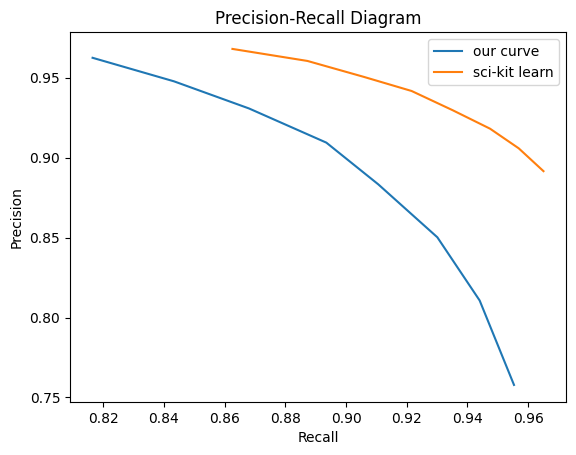

In [13]:
# We create a comparative Precision Recall curve that test for 20 different weights 
pr_curves([our_logistic_regression, scikit_logistic_regression],[x_train,y_train],'LG',size=20)

##### ROC curves

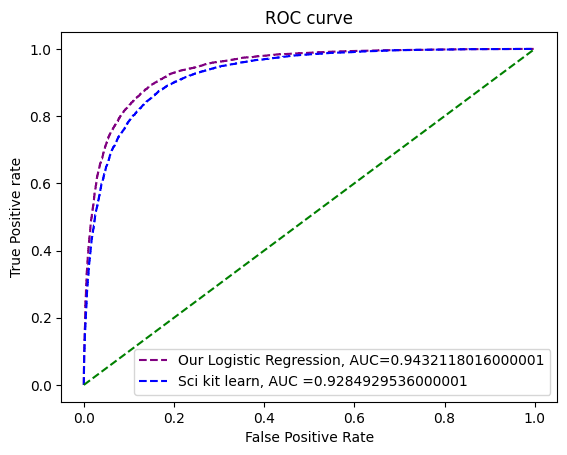

In [14]:
# Roc Curve for the 2 classifiers
roc_curve([our_logistic_regression,scikit_logistic_regression], [x_test,y_test])

#### Naive Bayes
In this part we will compare our Naive Bayes algorithm with that of sci-kit learn using the diagrams above 

In [15]:
scikit_naive_bayes = BernoulliNB()
our_naive_bayes = NaiveBayes(alpha=0.001)

scikit_naive_bayes.fit(x_train,y_train)
our_naive_bayes.fit(x_train,y_train)

y_pred1 = our_naive_bayes.predict(x_test)
# y_pred2 = scikit_naive_bayes.predict(x_test)
our_naive_bayes.evaluate(y_test, y_pred1,verbose=True)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



array([0.85370708, 0.82352   , 0.83834188])

##### Learning Curves

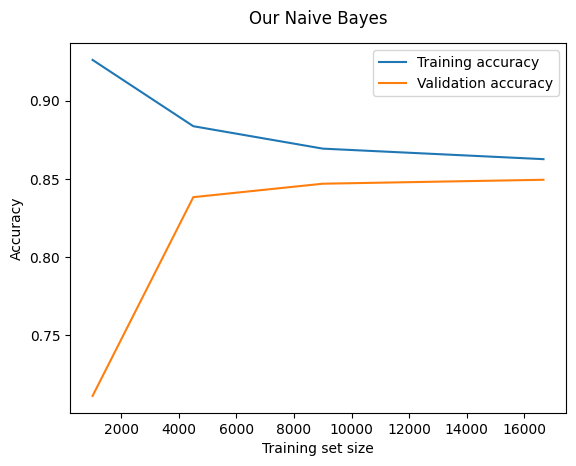


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.926000,0.711241
4500,0.883630,0.838280
9000,0.869296,0.846880
16666,0.862575,0.849400


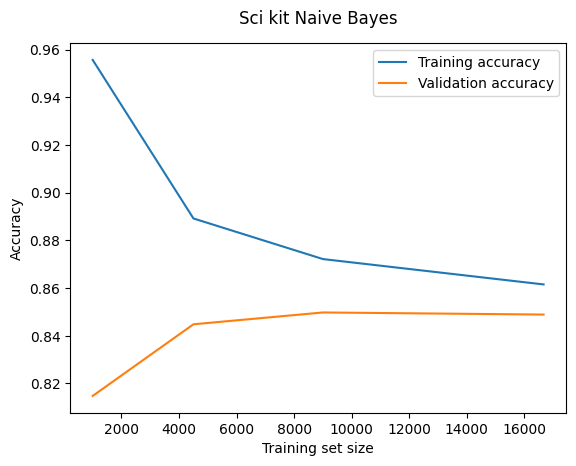


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.955667,0.81476
4500,0.889185,0.84480
9000,0.872148,0.84976
16666,0.861514,0.84888


In [16]:
my_learning_curve(estimator = our_naive_bayes, X = x_train, y = y_train,  train_sizes = [1000,4500,9000,16666], scoring = 'accuracy',title="Our Naive Bayes",cv=3)
my_learning_curve(estimator = scikit_naive_bayes, X = x_train, y = y_train, train_sizes = [1000,4500,9000,16666], scoring = 'accuracy',title="Sci kit Naive Bayes", cv=3)

##### PR curve for Naive Bayes 

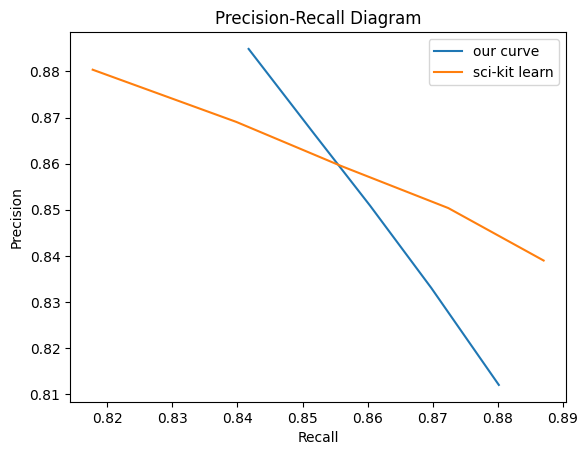

In [17]:
#pr_curves([our_naive_bayes, scikit_naive_bayes],[x_train,y_train],'NB',size=20)
pr_curves([our_naive_bayes, scikit_naive_bayes],[x_train,y_train],'NB',size=10)
# pr(our_naive_bayes, [x_train, y_train], 'our')
# pr(scikit_naive_bayes, [x_train, y_train], 'sklearn')

In [38]:
roc_curve([our_naive_bayes,scikit_naive_bayes], [x_test,y_test])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### AdaBoost
In this part we will compare our Naive Bayes algorithm with that of sci-kit learn using the diagrams above 

In [6]:
# First we initialize the classifiers 
our_adaboost = AdaBoost()
scikit_adaboost = AdaBoostClassifier(n_estimators=70)

# Fit the training data to the classifiers
our_adaboost.fit(x_train, y_train, 70)
scikit_adaboost.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=70)

##### Learning Curves

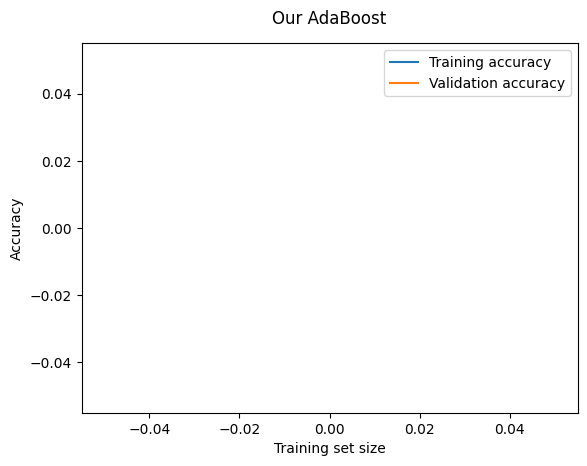


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,NaN,NaN
5000,NaN,NaN
10000,NaN,NaN
15000,NaN,NaN
20000,NaN,NaN


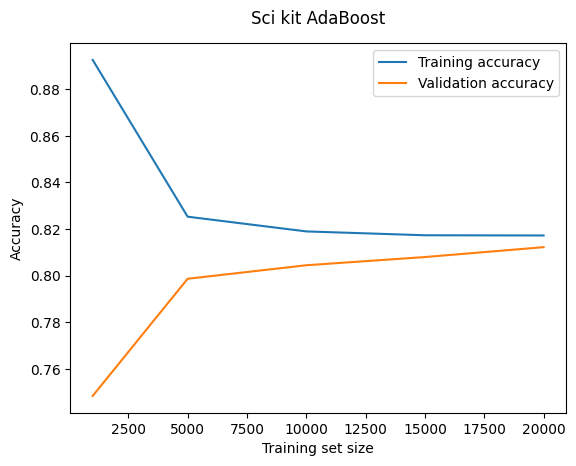


Learning Curve Data:


,Training Accuracy,Validation Accuracy
Training Set Size,,
1000,0.892600,0.74840
5000,0.825320,0.79868
10000,0.819000,0.80448
15000,0.817347,0.80800
20000,0.817260,0.81224


In [7]:
# Learning curve for our classifiers
my_learning_curve(estimator = our_adaboost, X = x_train, y = y_train, train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title="Our AdaBoost")
my_learning_curve(estimator = scikit_adaboost, X = x_train, y = y_train, train_sizes = [1000,5000,10000,15000,20000], scoring = 'accuracy',title="Sci kit AdaBoost")

##### Precision-Recall Curves

In [10]:
# We create a comparative Precision Recall curve that test for 20 different weights 
pr_curves([our_adaboost, scikit_adaboost],[x_train,y_train],'AB',size=20)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Part 3:
For this Part we made a simple Rnn implementation using tf keras. The Rnn is made of only 3 perceptrons:
 - Reshape to correctly input the data to the simple RNN perceptron
 - The simple RNN perceptron with some custom parameters
 - Dense perceptron with sigmoid activation function in order to return a value between 0 and 1

##### Create Word Embedings

In [4]:
from tqdm import tqdm

train_doc_length = 0
for doc in tqdm(x_train_imdb):
  tokens = str(doc).split()
  train_doc_length += len(tokens)


VOCAB_SIZE = 100000
SEQ_MAX_LENGTH = 250
vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, 
                                               output_mode='int', 
                                               ngrams=1, name='vector_text',
                                               output_sequence_length=SEQ_MAX_LENGTH)
with tf.device('/CPU:0'):
  vectorizer.adapt(x_train_imdb)


100%|██████████| 25000/25000 [00:00<00:00, 43677.98it/s]


###### 

In [5]:
def get_bigru(num_layers=1, emb_size=64, h_size=64):
  inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='txt_input')
  x = vectorizer(inputs)
  x = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                output_dim=emb_size, name='word_embeddings',
                                mask_zero=True)(x)
  for n in range(num_layers):
    if n != num_layers - 1:
      x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=h_size, 
                              name=f'bigru_cell_{n}', 
                              return_sequences=True,
                              dropout=0.2))(x)
    else:
      x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=h_size, 
                                        name=f'bigru_cell_{n}',
                                        dropout=0.2))(x)

  x = tf.keras.layers.Dropout(rate=0.5)(x)
  o = tf.keras.layers.Dense(units=1, activation='sigmoid', name='lr')(x)
  return tf.keras.models.Model(inputs=inputs, outputs=o, name='simple_rnn')




In [6]:
bigru_rnn = get_bigru()
print(bigru_rnn.summary())

Model: "simple_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 txt_input (InputLayer)      [(None, 1)]               0         
                                                                 
 vector_text (TextVectoriza  (None, 250)               0         
 tion)                                                           
                                                                 
 word_embeddings (Embedding  (None, 250, 64)           5139904   
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 128)               49920     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [12]:
bigru_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['binary_accuracy'])

history = bigru_rnn.fit(x=x_train_imdb, y=y_train,
               epochs=3, verbose=1, batch_size=64)

Epoch 1/3
  4/391 [..............................] - ETA: 51s - loss: 0.6941 - binary_accuracy: 0.4883

KeyboardInterrupt: 

In [34]:
print(bigru_rnn.evaluate(x_test_imdb, y_test))

782/782 [==============================] - 14s 16ms/step - loss: 0.5830 - binary_accuracy: 0.8385
[0.5830182433128357, 0.8385199904441833]


#### Diagrams

In [7]:
def mlp_learning_curve(model,x_train, y_train, train_sizes):
    training_acc = []
    val_acc = []
    
    for size in train_sizes:
        learning_history = model.fit(x=x_train[:size], y=y_train[:size], epochs=3, verbose=0, batch_size=64, validation_split=0.2)
        max_train_accuracy_reached = learning_history.history['binary_accuracy'][-1]
        max_val_accuracy_reached = learning_history.history['val_binary_accuracy'][-1]

        training_acc.append(max_train_accuracy_reached)
        val_acc.append(max_val_accuracy_reached)
    plt.plot(train_sizes,training_acc,label='Training Accuracy')
    plt.plot(train_sizes, val_acc,label='Validation Accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Train Sizes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def loss_plot(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

##### Precision Recall Curve


782/782 [==============================] - 57s 72ms/step


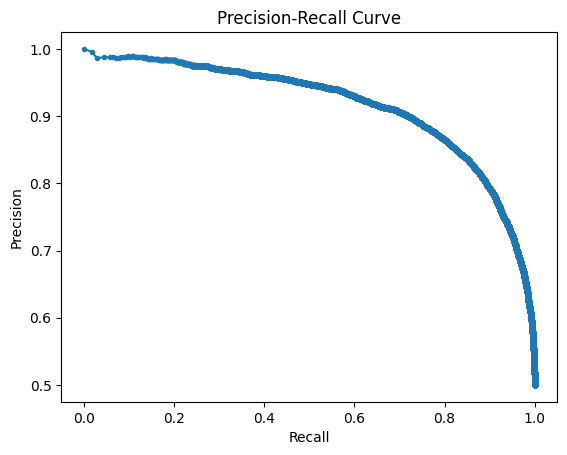

In [47]:
bigru_rnn=get_bigru()
bigru_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['binary_accuracy'])


# Evaluate the model
test_loss, test_acc = bigru_rnn.evaluate(x_test_imdb, y_test)

# Predict probabilities on the test set
y_probs = bigru_rnn.predict(x_test_imdb)

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

##### Learning curve 


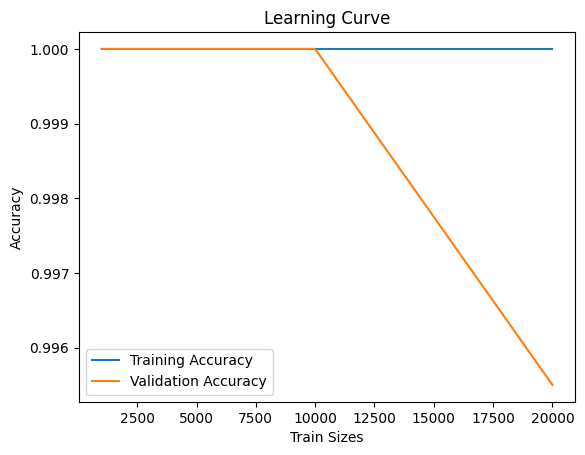

In [51]:

bigru_rnn2=get_bigru()
bigru_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['binary_accuracy'])
bigru_rnn2.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['binary_accuracy'])

mlp_learning_curve(model = bigru_rnn, x_train = x_train_imdb, y_train = y_train, train_sizes = [1000,5000,10000,20000])

##### Loss Plot


In [9]:
bigru_rnn1=get_bigru()
initial_learning_rate = 0.01
bigru_rnn1.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps=500,decay_rate=0.96,staircase=True)),
                   metrics=['binary_accuracy'])
history = bigru_rnn1.fit(x=x_train_imdb, y=y_train,
               epochs=5, verbose=1, batch_size=64, validation_split=0.2)
loss_plot(history)

Epoch 1/5
313/313 [==============================] - 46s 134ms/step - loss: 0.4515 - binary_accuracy: 0.7750 - val_loss: 0.2697 - val_binary_accuracy: 0.8918
Epoch 2/5
313/313 [==============================] - 41s 132ms/step - loss: 0.1496 - binary_accuracy: 0.9457 - val_loss: 0.3346 - val_binary_accuracy: 0.8722
Epoch 3/5
313/313 [==============================] - 41s 132ms/step - loss: 0.0410 - binary_accuracy: 0.9862 - val_loss: 0.4299 - val_binary_accuracy: 0.8768
Epoch 4/5
291/313 [==========================>...] - ETA: 2s - loss: 0.0179 - binary_accuracy: 0.9941